In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
#np.random.seed(1)


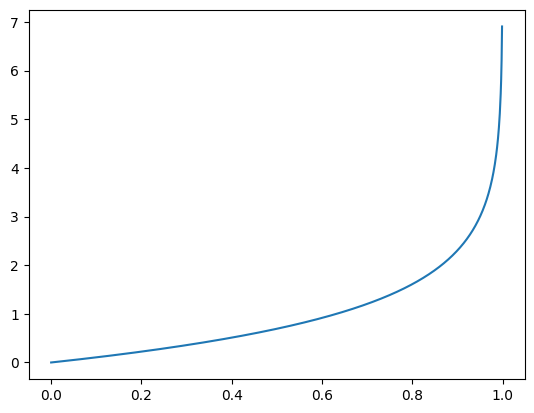

In [2]:
#true quantile function
u_grid = np.arange(0,1,0.001)
N = len(u_grid)
Q_true = stats.expon.ppf(u_grid, scale=1) 
plt.plot(u_grid,Q_true)

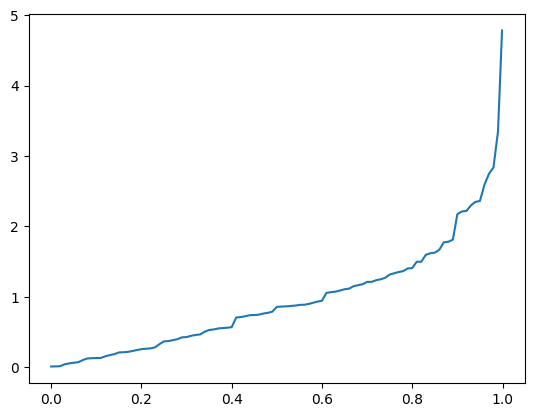

In [3]:
#quantile function of empirical distribution

def Quantile(u_grid,data):
    ecdf = stats.ecdf(data)
    y = ecdf.cdf.quantiles
    x = ecdf.cdf.probabilities
    Q_emp = np.interp(u_grid,x,y)
    return Q_emp

data = stats.expon.rvs(size=100)
#data = pd.read_csv("exponential_data_sample_1000_rate_1_seed_123.csv")
#data = data["x"]
Q_emp = Quantile(u_grid,data)
plt.plot(u_grid,Q_emp)



In [4]:
def convex_projection(u_grid,Q_emp):
    n = len(u_grid)
    Q = cp.Variable(n)
    objective = cp.Minimize(cp.sum_squares(Q-Q_emp))
    
    constraints = [Q[0] == 0] 
    constraints += [Q[i] <= Q[i+1] for i in range(n - 1)]  # monotonicity
    constraints += [Q[i+2] - 2*Q[i+1] + Q[i] >= 0 for i in range(n - 2)]  # convexity, second difference > 0

    prob = cp.Problem(objective,constraints)
    result = prob.solve(solver=cp.CLARABEL)
    #result = prob.solve()
    return (Q.value)
    

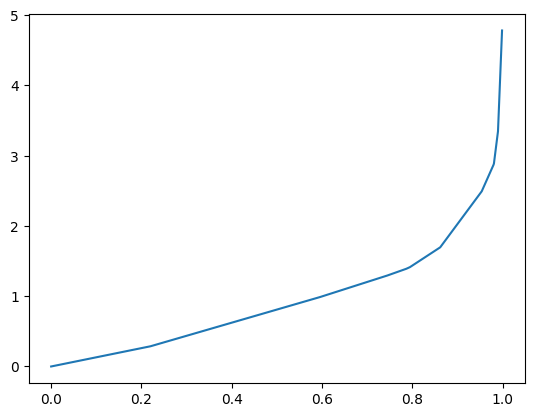

In [5]:
Q_conv = convex_projection(u_grid,Q_emp)
plt.plot(u_grid,Q_conv)

In [7]:
def L2distance(u_grid,Q_true,Q_conv):
    n = len(u_grid)
    return np.sqrt((np.sum(Q_true - Q_conv)**2)/n)
x = L2distance(u_grid,Q_true,Q_conv)
x

np.float64(1.5988049965586706)

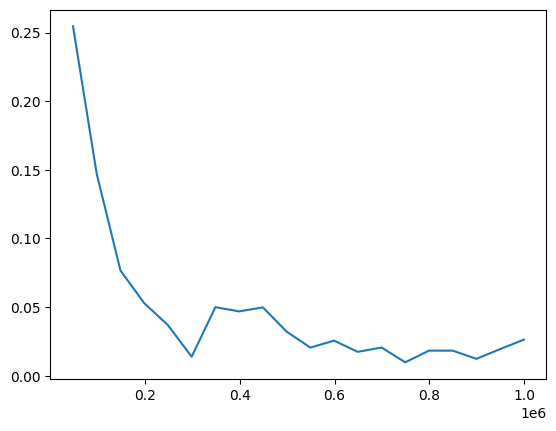

In [ ]:
def convergence_Wasserstein(u_grid,Q_true,data,start,end,step):
    dists = np.zeros((end - start)//step + 1)
    i = 0
    num_samples = start
    while(num_samples <= end):
        samples = data[:num_samples]
        Q_emp = Quantile(u_grid,samples)
        Q_conv = convex_projection(u_grid,Q_emp)
        dists[i] = L2distance(u_grid,Q_true,Q_conv)
        i += 1
        num_samples += step
    
    return dists
    

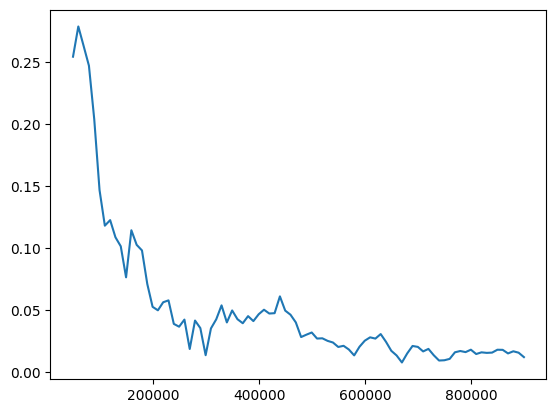

In [61]:
#run the simulation with fixed parameters
data = pd.read_csv("exponential_data_sample_1e+06_rate_1.csv")
data = data["value"]
start = 49000
end = 900000
step = 10000
dists = convergence_Wasserstein(u_grid,Q_true,data,start,end,step)
x = np.arange(start,end,step)
plt.plot(x,dists)

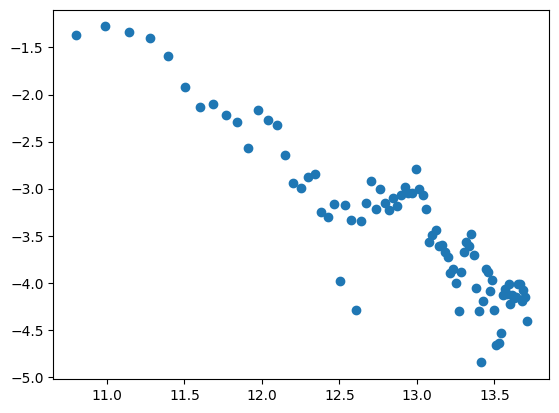

In [65]:
df = pd.DataFrame({'x': x, 'dists': dists})
df.to_csv("Data_Wasserstein.csv", index=False)
plt.scatter(np.log(x),np.log(dists))

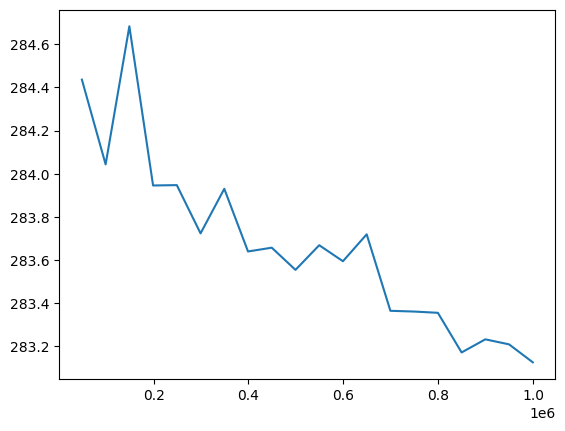

In [57]:
#run it with random data points and different parameters
data = stats.expon.rvs(scale=10,size=1000000) # change sample size and rate
#change the parameters
start = 49000
end = 1000000
step = 50000
dists = convergence_Wasserstein(u_grid,Q_true,data,start,end,step)
x = np.arange(start,end,step)
plt.plot(x,dists)



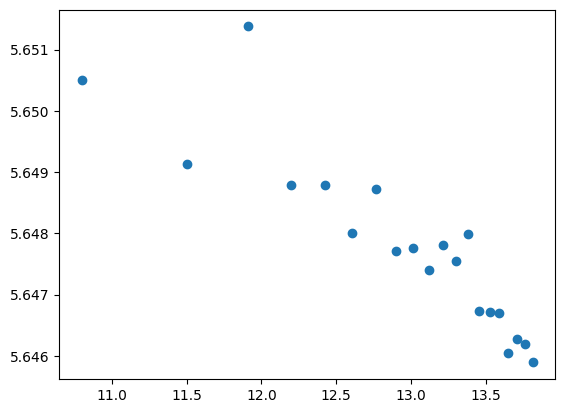

In [58]:
#log-log plot
plt.scatter(np.log(x),np.log(dists))